In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from tqdm import tqdm_notebook
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

def feature_extract_averages(file):
    y, sr = librosa.load(file, sr=None)
    
    hop_length = 512
    
    # Separate harmonics and percussives into two waveforms
    y_harmonic, y_percussive = librosa.effects.hpss(y)    
    
    #Chroma Energy Normalized (CENS)
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    
    #Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, 
                                                 fmax = 8000)
    #Mel-Frequency Cepstral Coefficients (MFCC) features from the raw signal
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
    
    #Spectral Contrast
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    
    y_harmonic = np.mean(y_harmonic)
    y_percussive = np.mean(y_percussive)
    mel_spec = np.mean(mel_spec)
    mfcc = np.mean(mfcc)
    chroma_cens = np.mean(chroma_cens)
    spec_contrast = np.mean(spec_contrast)
    
    return [y_harmonic, y_percussive, chroma_cens, mfcc, mel_spec, 
            spec_contrast]

def getDataset(dataGroup, instrument, source):
    
    new_dir='Dataset/nsynth-'+dataGroup+'/audio/'     #set the audio directory (test, train, etc)
    dataframe_raw = pd.read_json(path_or_buf='Dataset/nsynth-'+dataGroup+'/examples.json', orient='index') #read all instruments from examples.json
    dataframe_specific = dataframe_raw.loc[dataframe_raw['instrument_family_str'] == instrument]           #narrow down by family (strings, etc)
    dataframe_specific = dataframe_specific.loc[dataframe_specific['instrument_source_str'] == source]     #narrow down by source (acoustic, etc)

    filenames = dataframe_specific.index.tolist()     #get filenames from our dataframe, put into list
    
    dictionary = {}
    for file in tqdm_notebook(filenames):             #for all files in filenames. Also,  tqdm is a loading bar
        features = feature_extract_averages((new_dir+file+'.wav')) #specify directory, file, then add .wav. we will perform feature_extract with the file
        dictionary[file] = features                       #make dictionary using file as rows - features as columns
    featureDf = pd.DataFrame.from_dict(dictionary, orient='index', #turn into dataframe
                                       columns=['y_harmonic', 'y_percussive', 'chroma_cens', 
                                                'mfcc', 'mel_spec', 'spec_contrast'])
    
    return featureDf #returns dataframe of features
    
def equalize_data(class1, class2):
    class1_copy = class1
    class2_copy = class2  
    if (class1_copy['y_harmonic'].count() < class2_copy['y_harmonic'].count()):
        while (class1_copy['y_harmonic'].count()<class2_copy['y_harmonic'].count()): 
            temp = [class1_copy, class1]
            class2_copy = pd.concat(temp)
        class2_copy = class2_copy[:class1_copy['y_harmonic'].count()]
    else:
        while (class2_copy['y_harmonic'].count()<class1_copy['y_harmonic'].count()):
            temp = [class2_copy, class2]
            class2_copy = pd.concat(temp)
        class2_copy = class2_copy[:class1_copy['y_harmonic'].count()]
    return (class1_copy, class2_copy)

def count_errors(predictions):
    count = 0;
    for pred in predictions:
        if (pred[0] != pred[1]):
            count += 1
    return count;

print('functions declared')


functions declared


In [2]:
CLASS_NAMES=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'synth_lead', 'vocal']

SOURCE_NAMES=['acoustic', 'electronic', 'synthetic']
DATA_GROUPS=['test', 'valid', 'train']

dataGroup = DATA_GROUPS[0]    #SET IF YOU WANT TEST, TRAIN, OR VALID (IF YOU HAVE IT)
source = SOURCE_NAMES[0]      #SET ACOUSTIC, ELECTRONIC, SYNTHETIC

# get string members from dataset
string_df_test = getDataset('test', 'string', 'acoustic')

# get keyboard members
keyboard_df_test = getDataset('test', 'keyboard', 'acoustic')

# get string members from dataset
string_df_valid = getDataset('valid', 'string', 'acoustic')

# get keyboard members
keyboard_df_valid = getDataset('valid', 'keyboard', 'acoustic')

In [18]:
# balance the datasets
(string_df_test, keyboard_df_test) = equalize_data(string_df_test, keyboard_df_test)
input_df_test = pd.concat([string_df_test, keyboard_df_test])

(string_df_valid, keyboard_df_valid) = equalize_data(string_df_valid, keyboard_df_valid)
input_df_valid = pd.concat([string_df_valid, keyboard_df_valid])

# adding targets to dataframes
string_df_test['target'] = 8
keyboard_df_test['target'] = 4

string_df_valid['target'] = 8
keyboard_df_valid['target'] = 4

# randomize datasets
input_df_test = input_df_test.sample(frac=1).reset_index(drop=True)
input_df_valid = input_df_valid.sample(frac=1).reset_index(drop=True)

# creating input and target arrays
feature_names = ['y_harmonic', 'y_percussive', 'chroma_cens', 'mfcc', 'mel_spec', 'spec_contrast']

x_test = input_df_test[feature_names].values.tolist()
# encoding target as 0 for keyboard, 1 for string
y_test = input_df_test['target'].map(lambda target: 0 if (target == 4) else 1).values.tolist()

x_valid = input_df_valid[feature_names].values.tolist()
# encoding target as 0 for keyboard, 1 for string
y_valid = input_df_valid['target'].map(lambda target: 0 if (target == 4) else 1).values.tolist()

In [19]:
def simple_decision_tree(max_depth):
    # hyperparameters
    # max_depth of 4 seems to work well for training with validation set

    # create a scikit-learn tree based on validation set
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf = clf.fit(x_valid, y_valid)

    # make predictions
    predictions_test = np.vstack((y_test, clf.predict(x_test).tolist())).T
    predictions_valid = np.vstack((y_valid, clf.predict(x_valid).tolist())).T

    data_length_test = len(predictions_test)
    data_length_valid = len(predictions_valid)

    num_errors_test = count_errors(predictions_test)
    num_errors_valid = count_errors(predictions_valid)

    # calculating valid and test error to two decimal places
    validErrorPercentage = round(num_errors_valid / data_length_valid * 100, 2);
    testErrorPercentage = round(num_errors_test / data_length_test * 100, 2)

    errorLabels = ('Validation Set Error', 'Test Set Error')
    plt.figure(0)
    plt.title("Error in Validation vs Test")
    plt.ylabel("Error (%)")
    plt.bar('Valid', validErrorPercentage)
    plt.bar('Test', testErrorPercentage)

    print('Validation set error percentage: ', validErrorPercentage)
    print('Test set error percentage: ', testErrorPercentage)


Validation set error percentage:  9.46
Test set error percentage:  10.95


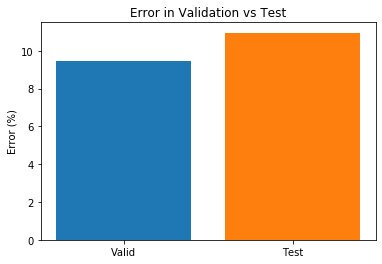

In [34]:
# fit a tree to our data and plot error
simple_decision_tree(4)

In [39]:
classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=42
)
classifier.fit(x_valid, y_valid)
predictions_valid = classifier.predict(x_test)
results_test = confusion_matrix(y_test, predictions_valid)
predictions_valid = classifier.predict(x_valid)
results_valid = confusion_matrix(y_valid, predictions_valid)

In [40]:
num_errors_test = results_test[0][1] + results_test[1][0]
num_errors_valid = results_valid[0][1] + results_valid[1][0]

# calculating valid and test error to two decimal places
validErrorPercentage = round(num_errors_valid / data_length_valid * 100, 2);
testErrorPercentage = round(num_errors_test / data_length_test * 100, 2)

errorLabels = ('Validation Set Error', 'Test Set Error')
plt.figure(0)
plt.title("Error in Validation vs Test")
plt.ylabel("Error (%)")
plt.bar('Valid', validErrorPercentage)
plt.bar('Test', testErrorPercentage)

print('Validation set error percentage: ', validErrorPercentage)
print('Test set error percentage: ', testErrorPercentage)

NameError: name 'data_length_valid' is not defined